In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import poisson, halfnorm
from scipy.ndimage import gaussian_filter
from copy import copy
import multiprocessing 
import pandas as pd
from matplotlib import rc, cm
from itertools import product
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D

rc('text', usetex=True)
rc('font', family='serif')

## Helper Functions

In [2]:
## Round to nearest value on axis
def fn(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return array[idx-1]
    else:
        return array[idx]
    
def generatePlaceFields1D(N,xaxis,L):
    # N: number of neurons
    # L: length of the linear track
    # dL: spatial discretization
    
    
    L = abs(xaxis[-1]-xaxis[0])
    dL = xaxis[1]-xaxis[0]
    f = np.zeros((N,xaxis.size))
    for i in range(N):
        # draw place field parameters randomly
        m = np.random.poisson(1) + 1   # number of place fields
        mu = np.random.uniform(xaxis.min(),xaxis.max(),m)  # place field centers
        sigma = np.random.uniform(dL,L/4,m) # place field width
        f0 = np.random.uniform(0,10,m) # maximal firing rate
        for j in range(m):
            f[i] = f[i] + f0[j] * np.exp(-(xaxis-mu[j])**2/sigma[j]**2)
    
    return f

def h(x,f,xaxis,dL):
# evaluates the place fields on a grid
# returns spiking frequencies at respective locations from x
    bins = xaxis-dL/2
    ind = np.digitize(x,bins) - 1
    hx = f[:,ind]
    
    return hx
    
    
def poisson_mean(spikes, i, x_k, x, time_bucket_length):
    if len(np.where(x==x_k)[0]) > 0:
        return spikes[np.where(x==x_k),i].sum()/(len(np.where(x==x_k)[0]) * time_bucket_length)
    return 0

def calculate_poisson(spikes, x, xaxis, time_bucket_length):
    poisson = {}
    num_neurons = spikes.shape[1]
    for x_k in xaxis:
        for i in range(num_neurons):
            pm = poisson_mean(spikes, i, x_k, x, time_bucket_length)
            poisson[i, x_k] = pm
    return poisson

def estimate_place_fields(spikes, X, xaxis, dt, sigma=40):
    poisson_dict = calculate_poisson(spikes, X, xaxis, dt)
    poisson_series = pd.Series(poisson_dict).reset_index()
    poisson_series.columns = ['neuron', 'location', 'poisson_mean']
    poisson_series = poisson_series.sort_values(['neuron', 'location']).reset_index(drop=True)
    estimated_place_fields = np.array(poisson_series.pivot(index='neuron',columns='location'))
    smoothed_place_fields = np.apply_along_axis(lambda x: gaussian_filter(x, sigma=sigma), 1, estimated_place_fields)
    return estimated_place_fields, smoothed_place_fields

def resample(x,w,N):
    if x.shape[0] == 2:
        ix = np.random.choice(np.arange(x.shape[1]), p=w, size=N)
        x_r = x[:,ix]
    else:
        x_r = np.random.choice(x, p=w, size=N)
    w_r = np.ones(N) * (1.0/N)
    return x_r,w_r

## Diffusion Model

### Generating Data

### Simple Diffusion Model
$$dx =  \sigma_x \times dW_t$$
$$dW_t \sim \mathcal{N} (0, dt)$$
$dt$ somewhere around $0.1-0.001$, test and check.
$$p(x_t | x_{t-dt} ) = \mathcal{N} ( x_t; x_{t-1}, \sigma_x^2 \times dt )$$

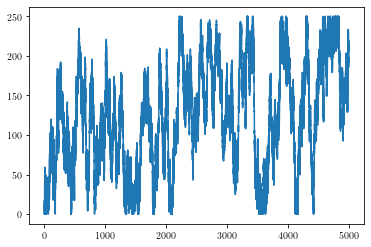

In [62]:
T = 5000
dt = 0.01
t = np.arange(0,T,dt)
M = 10 # number of neurons
L = 250 # total length
dL = 0.1
P = 1000
Peff_min = 0.5
xaxis = np.arange(0,L,dL) + dL/2 # center of bins
find_nearest = np.vectorize(lambda x: fn(xaxis, x))

params = {
    "sigma": 10,
    "dt": dt,
    "xaxis": xaxis, # axis for placefields
    "dL": dL,
    "T": T,
    "P": P,
    "Peff_min": Peff_min,
    "L": L
}

def generate_diffusion_trajectory(params):
    X = np.zeros(int(T/dt)) 
    X[0] = 0
    
    for i in np.arange(1,int(T/dt)):
        x = np.copy(X[i-1])
        # integrate one timestep using Euler scheme
        X[i] = x + params["sigma"] * np.random.normal(0,np.sqrt(dt))
        if X[i] < 0:
            X[i] = 0 # put particle to boundary
        elif X[i] > L:
            X[i] = L # put particle to boundary
            
    X = find_nearest(X)
    return X

X = generate_diffusion_trajectory(params)
        
plt.plot(t,X)
plt.show()

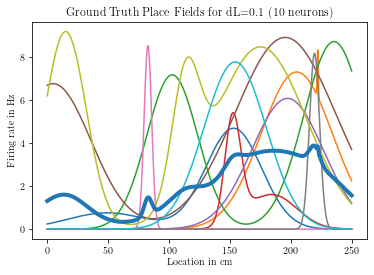

In [17]:
f = generatePlaceFields1D(M,xaxis,L)
params["f"] = f
plt.plot(xaxis,np.transpose(f))
plt.plot(xaxis,np.sum(f,0)/M,linewidth=4)
plt.title("Ground Truth Place Fields for dL={} ({} neurons)".format(dL, M))
plt.ylabel("Firing rate in Hz")
plt.xlabel("Location in cm")
plt.show()

### Combine trajectories with spikes

In [18]:
H = h(X,f,xaxis,dL)
dN = np.random.poisson(H * dt)
spikes = dN.transpose()

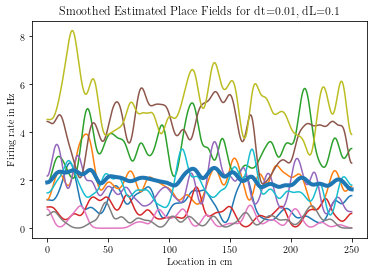

In [37]:
estimated_place_fields, smoothed_place_fields = estimate_place_fields(spikes, X, xaxis, dt, sigma=40)
plt.plot(xaxis,np.transpose(smoothed_place_fields))
plt.plot(xaxis,np.sum(smoothed_place_fields,0)/M,linewidth=4)
plt.title("Smoothed Estimated Place Fields for dt={}, dL={}".format(dt, dL))
plt.ylabel("Firing rate in Hz")
plt.xlabel("Location in cm")
plt.show()

### Split Data

In [38]:
X_train, X_validation, X_test = np.split(X, [int(.6*len(X)), int(.8*len(X))])
spikes_train, spikes_validation, spikes_test = np.split(spikes, [int(.6*len(spikes)), int(.8*len(spikes))])
estimated_place_fields, smoothed_place_fields = estimate_place_fields(spikes_train, X_train, xaxis, dt)
params["estimated_place_fields"] = estimated_place_fields
params["smoothed_place_fields"] = smoothed_place_fields

### Diffusion PF

In [39]:
def diffusion_pf(spikes, params):
    T = params["T"]
    dt = params["dt"]
    P = params["P"]
    sigma = params["sigma"]
    Peff_min = params["Peff_min"]
    L = params["L"]
    xaxis = params["xaxis"]
    place_fields = params["smoothed_place_fields"]
    dL = params["dL"]
    t = int(T/dt)
    
    x = np.zeros((t, P))
    w = np.full((t, P), 1/P)
    
    def boundary(x_t):
        if x_t < 0:
            return 0 # put particle to boundary
        elif x_t > L:
            return L # put particle to boundary
        return x_t
            
    vec_boundary = np.vectorize(boundary)
    
    for i in range(1, t):
        # particle transition
        x[i] = x[i-1] + sigma * np.random.normal(0, np.sqrt(dt), P)
        x[i] = vec_boundary(x[i])
        
        # weight update
        w[i] = w[i-1] * np.prod( poisson.pmf(spikes[i],h(x[i],place_fields,xaxis,dL).transpose()*dt) , 1)

        w[i] /= np.sum(w[i])
        
        while np.isnan(np.sum(w[i])):
            # all particles have 0 posterior probability, so we need to resample from the uniform
            x[i] = np.random.uniform(0, L, P)
            w[i] = (1/P) * np.prod( poisson.pmf(spikes[i],h(x[i],place_fields,xaxis,dL).transpose()*dt) , 1)
            w[i] /= np.sum(w[i])
        
        if 1 / np.sum(w[i] ** 2) < Peff_min * P:
            x[i], w[i] = resample(x[i], w[i], P)
                   
    return x, w

In [40]:
x_pf, w_pf = diffusion_pf(spikes, params)

In [41]:
mu = np.sum(x_pf * w_pf, 1)
mean_validation_err = abs(mu[len(X_train):len(X_train)+len(X_validation)]-X_validation).mean()
mean_test_err = abs(mu[len(X_train)+len(X_validation):]-X_test).mean()

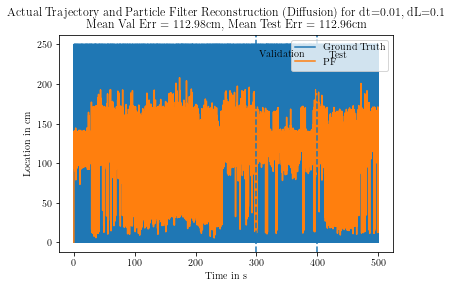

In [42]:
plt.plot(t,X)
plt.plot(t,mu)
plt.title("Actual Trajectory and Particle Filter Reconstruction (Diffusion) for dt={}, dL={}\n Mean Val Err = {:.2f}cm, Mean Test Err = {:.2f}cm".format(dt, dL, mean_validation_err, mean_test_err))
plt.legend(['Ground Truth', 'PF'])
plt.ylabel("Location in cm") 
plt.xlabel("Time in s")
plt.axvline(len(X_train) * dt, ls='--')
plt.axvline((len(X_train) + len(X_validation)) * dt, ls='--')
plt.figtext(0.59,0.8,"Validation")
plt.figtext(0.75,0.8,"Test")
plt.show()

### Parameter Variation and Estimation for Diffusion PF

In [26]:
def get_error_for_sigma(X, spikes, sigma):
    params["sigma"] = sigma
    x_pf, w_pf = diffusion_pf(spikes, params)
    mu = np.sum(x_pf * w_pf, 1)
    mean_validation_err = abs(mu-X).mean()
    return mean_validation_err 

def get_error_for_sigma_with_range(sigma):
    return get_error_for_sigma(X_validation, spikes_validation, sigma)

In [27]:
sigmas = [0.1, 0.5, 1, 2, 5, 10, 15, 20, 50]
validation_errors = []

In [ ]:
params["T"] = int(len(X_validation) * dt)
pool = multiprocessing.Pool()
validation_errors = pool.map(get_error_for_sigma_with_range, sigmas)
params["T"] = T
params["sigma"] = 10

In [ ]:
plt.plot(sigmas, validation_errors)
plt.title("Parameter variation for diffusion particle filter model")
plt.ylabel("Mean L1 Error") 
plt.axvline(params["sigma"], ls='--')
plt.figtext(0.32,0.8,"True sigma = 10")
plt.xlabel("Sigma")

In [64]:
def fit_diffusion_model(X, dt):
    if len(X) > 1:
        diffs = np.diff(X[:,0])
    else:
        diffs = np.diff(X)
    analytic_sigma = (1/(X.shape[0] * dt)) * np.sum(diffs ** 2)
    analytic_sigma = np.sqrt(analytic_sigma)
    return analytic_sigma

In [59]:
est_sigma = fit_diffusion_model(X, dt)

In [67]:
true_sigmas = [0.01, 0.1, 0.5, 1, 2, 5, 10, 15, 20, 50, 100, 500, 1000, 5000]
predicted_true_sigma = []
for true_sigma in true_sigmas:
    params["sigma"] = true_sigma
    X = generate_diffusion_trajectory(params)
    min_sigma = fit_diffusion_model(X, params["dt"])
    predicted_true_sigma.append(min_sigma)

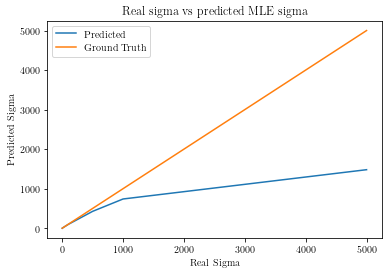

In [68]:
plt.plot(true_sigmas, predicted_true_sigma)
plt.plot(true_sigmas, true_sigmas)
plt.title("Real sigma vs predicted MLE sigma")
plt.ylabel("Predicted Sigma") 
plt.xlabel("Real Sigma")
plt.legend(['Predicted', 'Ground Truth'])